# AirBnB Berlin Insights 2022-2023: A Deep Dive into Pricing Patterns and Dynamics

## Table of Contents

1. [Introducing and Understanding the Data](#1)
2. [Objectives of the Study](#2)
3. [Data Wrangling](#3)
    3. [Data Gathering](#4)
    3. [Data Assessment](#5)
        3. [Assessment Summary](#6)
    3. [Data Cleaning](#7)
4. [Exploratory and Explanatory Analysis](#8)
    4. [Price Distribution](#9)
    4. [Location Effects on Prices](#10)
    4. [Price Dynamics](#11)
    4. [Patterns in Amenities Depending on Price](#12)
    4. [Most Influential Factors on Price](#13)
        4. [Correlation Analysis](#14)
        4. [Preparing Data for Regression](#15)
        4. [Linear Regression Analysis](#16)
        4. [Mutual Information Analysis](#17)
        4. [Non-Linear Regression](#18)
5. [Conclusions](#19)

<a id="1"></a> 
## Introducing and Understanding the Dataset

The dataset to be analyzed here was obtained from http://insideairbnb.com/get-the-data/ (a website which collects, analyses and stores AirBnB data for major cities around the world) consists of two distinct tables:
- **`listing.csv`**: This file contains information about the host and the property such as e.g. the location of the building and the host, its price and properties (amenities, number of bed and bathrooms, etc.). This data was obtained from a scheduled webscraping, which took place about every three months.
- **`calendar.csv`**: This file contains information about the availability, price and minimum and maximum nights to be rented for all the listings/properties in the `listings.csv` table for each of the 365 calendar day of the year. For example, a listing in `listings.csv` scraped on the 01-01-2023, will have 365 entries in the `calendar.csv` table corresponding to its availability and price, etc. for 01-01-2023 to 01-01-2024.

Each of these files contains about three months worth of data, i.e. the webscraping was performed roughly every three months and the data was stored was then stored in a file. Since we are not only interested in static information about a property scraped month but also about the dynamics in prices from different webscrapings, we gathered information for a whole year, distributed over four distinct `listings.csv` and `calendar.csv` files for each quarter of the year, corresponding to webscraping on 12/2022, 03/2023, 06/2023 and 09/2023.

<a id="2"></a> 
## Objectives of the Study

The present study aims to investigat the following questions:
- **How do prices between and within different districts differ from each other**: Are there any trends in the number of offerings in certain districts and how does the reputation of a certain district influence the prices? Are there any patterns in pricing obvious like e.g. a tendency of price decline with the distance to the center?
- **What are the dynamics of prices over the year**: Are there significant price differences or trends apparent from the scrapes throughout the year such as e.g. listings scraped in summer being more pricey than those from autumn? Can we see the effect of the inflation, which increased drastically from beginning of 2023? How does the time of booking influence the pricing?
- **Which properties of a listing affect prices the most**: Do listings with positive reviews tend to have a higher price than those without or with bad reviews? Are there any amenities which lead to higher prices? Can we find features which impact the price the most?

<a id="3"></a> 
# Data Wrangling

In the following, we will follow the standard data wrangling procedure which consists of **data gathering**, **data assessment** and **data cleaning**. This procedure will be done in preparation for the following analysis to bring the data to a form suitable for analysis and modelling.

<a id="4"></a> 
## Data Gathering

We start by loading the data which are separated in different files according to scraping date. Then, we check if all these tables have a common structure  and merge them into a single dataframe.

**Note**: During the data gathering phase, we will have to add a column to `calendar.csv`, which enables differentiation of the calendar dates according to the time the scrape was performed. This will be important for the analysis of price dynamics. We have to do this here since otherwise we lose track of the time information.

In [80]:
# Import the necessary libraries
import pandas as pd
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [82]:
# Get a list of all files in the directory
listings_list = glob.glob('data/airbnb-data/*/listings.csv')
calendar_list = glob.glob('data/airbnb-data/*/calendar.csv')

# Lists to which individual dataframes will be appended
df_listings_list = []
df_calendar_list = []
# Loop over filenames and read .csv files; append them to lists
for file_listings, file_calendar in zip(listings_list, calendar_list):
    df_listings_list.append(pd.read_csv(file_listings))
    df_calendar_list.append(pd.read_csv(file_calendar))
    
    # Merge the listings and calendar dfs based on their id in order to add the last_scraped date to the calendar
    df_calendar_list[-1] = pd.merge(df_calendar_list[-1], df_listings_list[-1][['id', 'last_scraped']], 
                                    left_on='listing_id', right_on='id', how='inner').drop(columns='id', axis=1)
    

Before concatenation, check if all the dataframes we just read in have exactly the same structure, i.e. if they all have the exact same column names and number of columns.

In [3]:
# Check if the column names are equal between all dataframes we just read
common_cols_listings = set(df_listings_list[0].columns)
common_cols_calendar = set(df_calendar_list[0].columns)
for df_listing, df_calendar in zip(df_listings_list[1:], df_calendar_list[1:]):
    # Compute the intersection of columns/find common columns
    common_cols_listings.intersection_update(df_listing.columns)
    common_cols_calendar.intersection_update(df_calendar.columns)
    
# Compare the original number of columns to the intersection: If both are equal, dfs can be stacked
print('Nr. common_cols', len(common_cols_listings), len(common_cols_calendar))
print('Nr. original columns', *[len(df.columns) for df in df_listings_list],
                              *[len(df.columns) for df in df_calendar_list])

Nr. common_cols 75 8
Nr. original columns 75 75 75 75 8 8 8 8


Finally, concatenate the dataframes into a single dataframe for the calendar dates as well as for the listings.

In [4]:
df_listings = pd.concat(df_listings_list, axis=0)
df_calendar = pd.concat(df_calendar_list, axis=0)

<a id="5"></a> 
## Data Assessment

Take a glimpse at both dataframes for a quick visual assessment.

In [5]:
df_listings.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3176,https://www.airbnb.com/rooms/3176,20230916061000,2023-09-16,city scrape,Rental unit in Berlin · ★4.63 · 1 bedroom · 2 ...,This beautiful first floor apartment is situa...,The neighbourhood is famous for its variety of...,https://a0.muscache.com/pictures/243355/84afcf...,3718,...,4.69,4.92,4.62,First name and Last name: Nicolas Krotz <br/> ...,f,1,1,0,0,0.85
1,9991,https://www.airbnb.com/rooms/9991,20230916061000,2023-09-16,city scrape,Rental unit in Berlin · ★5.0 · 4 bedrooms · 7 ...,4 bedroom with very large windows and outstand...,Prenzlauer Berg is an amazing neighbourhood wh...,https://a0.muscache.com/pictures/42799131/59c8...,33852,...,5.00,4.86,4.86,03/Z/RA/003410-18,f,1,1,0,0,0.08
2,14325,https://www.airbnb.com/rooms/14325,20230916061000,2023-09-16,city scrape,Rental unit in Berlin · ★4.67 · Studio · 1 bed...,The apartment is located on the upper second f...,NaN,https://a0.muscache.com/pictures/508703/24988a...,55531,...,4.84,4.58,4.42,NaN,f,4,4,0,0,0.16
3,16644,https://www.airbnb.com/rooms/16644,20230916061000,2023-09-16,city scrape,Condo in Berlin · ★4.72 · 1 bedroom · 1 bed · ...,Light and sunny 2-Room-turn of the century-fla...,Our Part of Kreuzberg is just the best. Good v...,https://a0.muscache.com/pictures/73759174/e2ef...,64696,...,4.86,4.67,4.71,NaN,f,2,2,0,0,0.30
4,17904,https://www.airbnb.com/rooms/17904,20230916061000,2023-09-16,city scrape,Rental unit in Berlin · ★4.77 · Studio · 1 bed...,"- apt is available starting April 1, 2023<br /...",NaN,https://a0.muscache.com/pictures/d9a6f8be-54b9...,68997,...,4.92,4.87,4.65,NaN,f,1,1,0,0,1.81


In [6]:
df_calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,last_scraped
0,3176,2023-09-16,f,$83.00,$83.00,63.0,184.0,2023-09-16
1,3176,2023-09-17,f,$83.00,$83.00,63.0,184.0,2023-09-16
2,3176,2023-09-18,f,$83.00,$83.00,63.0,184.0,2023-09-16
3,3176,2023-09-19,f,$83.00,$83.00,63.0,184.0,2023-09-16
4,3176,2023-09-20,f,$83.00,$83.00,63.0,184.0,2023-09-16


Check for missing values and data types

In [7]:
df_calendar.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19480756 entries, 0 to 5736710
Data columns (total 8 columns):
 #   Column          Non-Null Count     Dtype  
---  ------          --------------     -----  
 0   listing_id      19480756 non-null  int64  
 1   date            19480756 non-null  object 
 2   available       19480756 non-null  object 
 3   price           19480368 non-null  object 
 4   adjusted_price  19480368 non-null  object 
 5   minimum_nights  19480730 non-null  float64
 6   maximum_nights  19480730 non-null  float64
 7   last_scraped    19480756 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 1.3+ GB


In [8]:
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53372 entries, 0 to 15716
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            53372 non-null  int64  
 1   listing_url                                   53372 non-null  object 
 2   scrape_id                                     53372 non-null  int64  
 3   last_scraped                                  53372 non-null  object 
 4   source                                        53372 non-null  object 
 5   name                                          53340 non-null  object 
 6   description                                   52660 non-null  object 
 7   neighborhood_overview                         28034 non-null  object 
 8   picture_url                                   53372 non-null  object 
 9   host_id                                       53372 non-null 

Do we have duplicates?

In [9]:
print(df_listings.duplicated().sum())
print(df_calendar.duplicated().sum())

0
0


How is the 'bathrooms_text' column organized?

In [10]:
df_listings['bathrooms_text'].value_counts()

1 bath               31792
1 shared bath         9998
1 private bath        3183
2 baths               3019
1.5 baths             2592
1.5 shared baths      1072
2 shared baths         569
2.5 baths              437
3 baths                163
0 shared baths         106
Half-bath               92
0 baths                 62
2.5 shared baths        49
3 shared baths          34
3.5 baths               33
4 baths                 31
Shared half-bath        27
4.5 baths               12
5 shared baths          12
8.5 shared baths        12
4 shared baths           9
5 baths                  8
7 baths                  7
6 baths                  6
Private half-bath        5
8 baths                  4
8.5 baths                1
7.5 baths                1
Name: bathrooms_text, dtype: int64

Create a copy of the listings dataframe which we will modify.

In [11]:
df_listings_clean = df_listings.copy()

#### Remove columns identified as unnecessary already here to make the following assesment easier.

In [12]:
remove_cols = ['license', 'bathrooms', 'scrape_id', 'listing_url', 'neighborhood_overview',
               'host_name', 'host_since', 'host_location', 'host_about', 'host_thumbnail_url',
               'host_picture_url', 'host_neighbourhood', 'source', 'name', 'description', 'calendar_updated',
               'calendar_last_scraped', 'neighbourhood_cleansed', 'neighbourhood', 'picture_url', 'host_id',
               'host_url']
df_listings_clean = df_listings.drop(columns=remove_cols, axis=1)

Check if there are any issues with the string type columns or if we can just easily convert them to our desired format:

In [13]:
df_listings_clean.select_dtypes(include='object').head()

,last_scraped,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,property_type,room_type,bathrooms_text,amenities,price,has_availability,first_review,last_review,instant_bookable
0,2023-09-16,NaN,NaN,30%,f,"['email', 'phone']",t,t,Pankow,Entire rental unit,Entire home/apt,1 bath,"[""Kitchen"", ""Crib"", ""Essentials"", ""Patio or ba...",$83.00,t,2009-06-20,2023-05-25,f
1,2023-09-16,NaN,NaN,0%,f,"['email', 'phone']",t,t,Pankow,Entire rental unit,Entire home/apt,2.5 baths,"[""Refrigerator"", ""TV with standard cable"", ""Ba...",$180.00,t,2015-08-09,2020-01-04,f
2,2023-09-16,within a few hours,86%,29%,f,"['email', 'phone', 'work_email']",t,t,Pankow,Entire rental unit,Entire home/apt,1 bath,"[""Wifi"", ""TV"", ""Refrigerator"", ""Heating"", ""Cof...",$70.00,t,2010-06-29,2021-06-21,f
3,2023-09-16,within a day,100%,50%,f,"['email', 'phone']",t,t,Friedrichshain-Kreuzberg,Entire condo,Entire home/apt,1 bath,"[""Kitchen"", ""Essentials"", ""Wifi"", ""TV"", ""High ...",$90.00,t,2010-06-04,2017-12-14,f
4,2023-09-16,within an hour,100%,96%,t,"['email', 'phone']",t,t,Neukölln,Entire rental unit,Entire home/apt,1 bath,"[""Long term stays allowed"", ""Kitchen"", ""Essent...",$25.00,t,2010-02-18,2022-12-01,f


Get an idea of relevant of columns which have missing values

In [14]:
df_listings_clean.columns[df_listings_clean.isna().sum()>0]

Index(['host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'bathrooms_text',
       'bedrooms', 'beds', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month'],
      dtype='object')

<a id="6"></a> 
### Assessment Summary

- A lot of useless columns since they either do not contain relevant information or pure text but we are for this analysis not interested in performing a NLP sentiment analysis: 
                             license, bathrooms, calendar_updated (does not contain any data), scrape_id, 
                             listing_url, neighborhood_overview, calendar_last_scraped,
                             host_name, host_since, host_location, host_about, host_thumbnail_url, 
                             host_picture_url, host_neighbourhood, source, name, description
         
- We have quite a few colums with miissing values:
                            'host_response_time', 'host_response_rate', 'host_acceptance_rate',
                            'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
                            'host_has_profile_pic', 'host_identity_verified', 'bathrooms_text',
                            'bedrooms', 'beds', 'first_review', 'last_review',
                            'review_scores_rating', 'review_scores_accuracy',
                            'review_scores_cleanliness', 'review_scores_checkin',
                            'review_scores_communication', 'review_scores_location',
                            'review_scores_value', 'reviews_per_month'

- 'neighborhood' column is unnecessary because we have more accurate data available in 'neighborhood_cleansed'. However, the data in 'neighborhood_cleansed' is far too fine-grained and even contains exact street names which is information we are not really interested in. We are mainly interested in the districts (actual neighborhoods) which are contained in the 'neighborhood_group_cleansed' column.

- 'listing_id' in calendar table is int instead of string
- 'available' in calendar table is string instead of boolean
- 'date' in calendar table is string instead of datetime object
- We have very few missing values in calendar table (less than 0.001 %) which can simply be removed

- 'id' is int instead of string

- 'host_response_rate' and 'host_acceptance_rate' are strings with trailing percentage symbols instead of floats

- 'host_response_time' is string but should be nominal categorical (and for modelling later on integer-encoded).

- 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'has_availability', 'instand_bookable' are strings instead of boolean (better 0 and 1 ints for modelling)
- 'host_verifications' is list of values. Should be separated into two boolean (0 and 1) columns for phone and e-mail.

- 'amenities' is list of values. Each amenity should have a separate boolean column

- 'price' is string and contains dollar symbol

- 'first_review' and 'last_review' are strings instead of datetime objects.

- bathroom column contains text and information about whether bathroom is shared or normal/private. Should be disentangled such that there is one column containing the number of bathrooms as float and another column specifying whether it is shared or not (boolean).

- 'last_scraped' is string instead of datetime object (Interesting for seeing price developments)

<a id="7"></a> 
## Data Cleaning

In this section we will start cleaning the data which we identified as relevant in order to get our tables in a format suitable for analyzing.

We will start by focusing on the listings table, which contains the most serious issues while for the calendar table we only need to convert some data types.

### Fix missing values part 1: Review Columns

The missing reviews seem to very similar to the number of missing dates of reviews:

In [15]:
df_listings_clean.isna().sum().sort_values(ascending=False).iloc[:15]

host_response_time             22163
host_response_rate             22163
host_acceptance_rate           18921
bedrooms                       11715
review_scores_value            10962
review_scores_checkin          10952
review_scores_location         10951
review_scores_accuracy         10940
review_scores_communication    10932
review_scores_cleanliness      10931
reviews_per_month              10365
first_review                   10365
review_scores_rating           10365
last_review                    10365
host_is_superhost               3725
dtype: int64

This indicates that those NaNs refer to apartments, which do not have any ratings yet. 

However, we gotta dig deeper to verify this. If all those missing values in review related columns appear at the same rows, this would give us a strong indication that they indeed refer to rows with no rating:

In [16]:
# Define columns to be investigated
review_columns = ['review_scores_value', 'review_scores_checkin', 'review_scores_location',
                  'review_scores_accuracy', 'review_scores_communication', 'review_scores_cleanliness',
                  'last_review', 'first_review', 'reviews_per_month', 'review_scores_rating']

# Get the indices of eachh of those columns which refer to NaN values
indices = []
for col in review_columns:
    indices.append(df_listings_clean[df_listings_clean[col].isna()].index)

# Compute the intersection of those NaN columns: Yields the common indices
common_values = indices[0]
for idx in indices[1:]:
    common_values = common_values.intersection(idx)

print('Number of NaN overlapping NaN rows: ', len(common_values))
print('Column with minimum value of NaN rows', np.array(list(map(len, indices))).min())

Number of NaN overlapping NaN rows:  10365
Column with minimum value of NaN rows 10365


Now, we have figured out that the rows with missing NaNs in review most probably indicate listings without any reviews, i.e. new listings or listings which have not been booked yet. Removing those would not be a good idea since not having bookings on a listing might indicate that people are not interested in that listing, which is valuable information.

Instead, we will fill those review rating columns with zeros as the other columns without reviews also have 0 ratings. Additionally, Since reviews with value of 0 are impossible within AirBnBs rating system, it also is easy to distinguish between rows with a very bad rating and rows with no rating (0 vs. 1).

Furthermore, we will add unreasonable dates for these columns to have a distinguishing factor 

In [17]:
# Replace missing values first by 0.0 in all the review related columns
df_listings_clean[review_columns] = df_listings_clean[review_columns].fillna(0.0)

In [18]:
# Now, replace those missing values encoded by 0.0 in review times time by unreasonable impossible dates
df_listings_clean[['last_review', 'first_review']] = df_listings_clean[['last_review', 'first_review']].replace({0.0 : '1970-01-01'})

In [19]:
# Convert review time columns to datetime format
df_listings_clean['first_review'] = pd.to_datetime(df_listings_clean['first_review'])
df_listings_clean['last_review'] = pd.to_datetime(df_listings_clean['last_review'])

Check if everything worked as expected:

In [20]:
df_listings_clean.isna().sum().sort_values(ascending=False).iloc[:15]

host_response_time           22163
host_response_rate           22163
host_acceptance_rate         18921
bedrooms                     11715
host_is_superhost             3725
beds                           821
host_total_listings_count       49
host_has_profile_pic            49
host_listings_count             49
host_identity_verified          49
bathrooms_text                  36
minimum_nights                   0
price                            0
amenities                        0
accommodates                     0
dtype: int64

### Fix Missing Values Part 2: Host and Bathroom Columns
1. Rows with missing values in 'host_listings_count', 'host_total_listings_count', 'host_identity_verified' and 'bathrooms_text' can be removed since there are only very few missing values (Less than 0.1 %) and especially for the listings_count columns imputation could be difficult. Furthermore, the bathroom column would require an imputation using a model like e.g. KNN to yield reasonable results with only a very little gain.

In [21]:
drops_columns = ['bathrooms_text', 'host_identity_verified', 'host_has_profile_pic', 
                 'host_total_listings_count', 'host_listings_count']

# Remove rows with missing in values in subset defined above
df_listings_clean = df_listings_clean.dropna(subset=drops_columns, how='any')

Check if everything worked:

In [22]:
df_listings_clean.isna().sum().sort_values(ascending=False).iloc[:7]

host_response_time      22095
host_response_rate      22095
host_acceptance_rate    18858
bedrooms                11692
host_is_superhost        3711
beds                      811
reviews_per_month           0
dtype: int64

### Fix missing values Part 3 and Clean: Rate and Response Columns

To fix these missing values, the following steps have to be performed:
1. Clean 'host_acceptance_rate' and 'host_response_rate' columns by removing '%' signs and conversion to float
2. For rows where we have a strong indication there they are nans because the host did not communicate
   => Set them to zero
3. For remaining missing values impute by mean or median or mode, respectively.
   Look at 5-number summary to figure out whether mean or median is more appropriate

#### 1. Clean 'host_acceptance_rate' and 'host_response_rate' columns by removing '%' signs and conversion to float

In [23]:
# Remove '%' sign from rate columns to prepare for imputation
df_listings_clean['host_acceptance_rate']  = df_listings_clean['host_acceptance_rate'].apply(lambda x: float(x.split('%')[0]) if pd.notna(x) else x)
df_listings_clean['host_response_rate'] = df_listings_clean['host_response_rate'].apply(lambda x: float(x.split('%')[0]) if pd.notna(x) else x)

#### 2. For rows where we have a strong indication there they are nans because the host did not communicate => Set them to zero

In [24]:
# Mask for obtaining  rows with 0 reviews and no responses => Probably no communications yet
mask = (  (df_listings_clean['last_review']<pd.to_datetime('01-01-1971'))
        & (df_listings_clean['host_acceptance_rate'].isna())
        & (df_listings_clean['host_response_time'].isna())
        & df_listings_clean['host_response_rate'].isna() )

# Replace host_response_time for those columns with new category and rate columns by 0.0
df_listings_clean.loc[mask, 'host_response_time'] = 'No Inquiries'
df_listings_clean.loc[mask, ['host_acceptance_rate', 'host_response_rate']] = 0.0

Check if everything worked as expected

In [25]:
df_listings_clean.isna().sum().sort_values(ascending=False).iloc[:7]

host_response_time      17253
host_response_rate      17253
host_acceptance_rate    14016
bedrooms                11692
host_is_superhost        3711
beds                      811
reviews_per_month           0
dtype: int64

#### 3. Look at 5-number summary to determine whether mean or median is more approprate for imputation

In [26]:
rate_columns = ['host_acceptance_rate', 'host_response_rate']
df_listings_clean.describe()[rate_columns]

,host_acceptance_rate,host_response_rate
count,39271.000000,36034.000000
mean,70.722798,80.487873
std,37.176015,36.146946
min,0.000000,0.000000
25%,50.000000,85.000000
50%,91.000000,100.000000
75%,100.000000,100.000000
max,100.000000,100.000000


The distributions for both of these columns seems to be highly right skewed. Almost 50 % of all hosts/offers have acceptancce and response rates of 100 %. Even though, choosing the mean might reflect our uncertainty about the reason for these missing values, going with the median is the better choice since we expect those missing values to stem from some bugs in the AirBnB app. Having problems with those values seems to be a common issue among many customers as confirmed by a search in the AirBnB forums.

Hence, also the remaining missing values for the response time will be replaced by its mode.

In [27]:
# Define dictionary for filling NaNs
fill_dict = {'host_acceptance_rate' : df_listings_clean['host_acceptance_rate'].median(),
             'host_response_rate' : df_listings_clean['host_response_rate'].median(),
             'host_response_time' : df_listings_clean['host_response_time'].mode()[0]}

# Fill NaNs
df_listings_clean = df_listings_clean.fillna(value=fill_dict)

Check if everything worked

In [28]:
df_listings_clean.isna().sum().sort_values(ascending=False).iloc[:5]

bedrooms             11692
host_is_superhost     3711
beds                   811
reviews_per_month        0
longitude                0
dtype: int64

### Fix missing values Part 4: Superhost

To fix the missing values of the superhost column, a simple imputation using the mode should be sufficient

In [29]:
df_listings_clean['host_is_superhost'] = df_listings_clean['host_is_superhost'].fillna(df_listings_clean['host_is_superhost'].mode()[0])

Check if everything worked

In [30]:
df_listings_clean.isna().sum().sort_values(ascending=False).iloc[:3]

bedrooms             11692
beds                   811
reviews_per_month        0
dtype: int64

### Digression: Clean remaining columns prior to fixing missing values in 'bedroms' and 'beds' columns

Our aim is to impute 'bedrooms' and 'beds' using a non-linear ML model since using the mean, median or mode to impute
these columns might lead to misleading results later, e.g. a very expensive and huge house would then have only a single bedroom, which obviously is wrong and might result in some difficult to interpret outliers.

However, prior to doing this imputation we first need to fix some issues with other columns, which will be important features for the model imputation strategy:

#### 1. Correct data types of 'id' column and convert strings in binary columns to actual binary integers

In [31]:
df_listings_clean['id'] = df_listings_clean['id'].astype(str)
df_listings_clean['host_is_superhost'] = df_listings_clean['host_is_superhost'].replace({'t' : 1, 'f' : 0})
df_listings_clean['host_has_profile_pic'] = df_listings_clean['host_has_profile_pic'].replace({'t' : 1, 'f' : 0})
df_listings_clean['host_identity_verified'] = df_listings_clean['host_identity_verified'].replace({'t' : 1, 'f' : 0})
df_listings_clean['has_availability'] = df_listings_clean['has_availability'].replace({'t' : 1, 'f' : 0})
df_listings_clean['instant_bookable'] = df_listings_clean['instant_bookable'].replace({'t' : 1, 'f' : 0})

#### 2.1. In the 'amenities' and 'host_verifications' columns we have lists encapsulated in strings. These lists contain potentially valuable/interesting information (e.g. whether a house has WIFI or a TV) which we need to format and disentangle. Since we need to do this twice, we wrote a function for that.

In [32]:
def disentangle_lists(df, column, num_thr=0, len_thr=100):
    """
    Processes and expands a DataFrame column containing lists (encapsulated in strings)
    of strings into individual binary columns.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing the column to be processed.
    - column (str): Name of the column in df that contains lists of strings.
    - num_thr (int, optional): Threshold below which newly created columns 
      (having a sum of values less than num_thr) will be dropped. Defaults to 0.
    - len_thr (int, optional): Maximum allowable length for unique string values in the lists. 
      Strings exceeding this length will not get individual columns. Defaults to 100.

    Returns:
    - pd.DataFrame: DataFrame with additional binary columns for each unique value found in the original lists. 
      Columns with sum of values below num_thr or string values with length greater than len_thr are dropped. 
      Original DataFrame remains unmodified.

    Notes:
    - Strings in the list columns are cleaned of '[', ']', and '"' characters, and are converted to lowercase.
    - Newly created columns are named as 'original_column_name_value' where 'value' is the unique string 
      value in the list, with spaces replaced by underscores.
    """
    # Make copy of df
    df_tmp = df.copy()

    # The actual list is given as a string. Extract the list from the string and convert strings inside list to a nice format
    df_tmp[column] = df_tmp[column].apply(lambda x: list(map(lambda s: s.replace('[','').replace(']','').replace('"','').lower().strip(),
                                                                      x.split(','))))
    # Use set operations to remove duplicates from the series
    unique_vals = set().union(*df_tmp[column])
    
    # Loop over unique values to create new binary columns for these
    for val in unique_vals:
        # Replace spaces by underscores for nice column names
        col = column + '_' + val.replace(' ','_')
        
        # Only consider values with a certain length to avoid different versions of whole sentences and add column
        if len(val)<=len_thr:
            df_tmp[col] = df_tmp[column].apply(lambda x: 1 if val in x else 0)

        # Remove previously added column if it mostly contains zeros
        if len(val)<=len_thr and df_tmp[col].sum()<=num_thr:
            df_tmp.drop(columns=col, axis=1, inplace=True)
        else:
            if len(val)<=len_thr: print('Column added: ',val, df_tmp[col].sum())
                
    # Drop original column
    df_tmp.drop(columns=column, axis=1, inplace=True)
            
    return df_tmp

#### 2.2. Apply the above function to the 'amenities' column, i.e. add a separate binary column for each significant amenity. We only consider here columns with amenities which are available in at least 10 % of the houses and with a rather short name (20 characters = 1 - 2 words). This is done because there are thousands of amenities with a lot of redundancy, largely because of some exotics or because sometimes a whole sentence was written.

In [33]:
df_listings_clean = disentangle_lists(df_listings_clean, 'amenities', num_thr=6000, len_thr=20)

Column added:  hangers 36612
Column added:  wifi 48004
Column added:  hair dryer 38974
Column added:  bathtub 12268
Column added:  freezer 11466
Column added:  body soap 10443
Column added:  hot water kettle 15212
Column added:  heating 40093
Column added:  dedicated workspace 19918
Column added:  smoke alarm 34928
Column added:  hot water 34281
Column added:  microwave 14137
Column added:  dining table 13249
Column added:  baking sheet 10601
Column added:  essentials 46105
Column added:  host greets you 11022
Column added:  single level home 7995
Column added:  shower gel 11663
Column added:  pets allowed 9726
Column added:  central heating 7820
Column added:  self check-in 11196
Column added:  refrigerator 29363
Column added:  toaster 11616
Column added:  kitchen 48998
Column added:  dishwasher 18235
Column added:  lock on bedroom door 7268
Column added:  bed linens 26861
Column added:  cleaning products 12850
Column added:  free street parking 14754
Column added:  patio or balcony 6

#### 2.3. Also disentangle the 'host_verifications' column

In [34]:
df_listings_clean = disentangle_lists(df_listings_clean, 'host_verifications', num_thr=100)

Column added:  'email' 49466
Column added:  'work_email' 6547
Column added:  'phone' 53181


#### 3. Remove dollar sign from price column and convert it to a string

In [35]:
df_listings_clean['price'] =df_listings_clean['price'].apply(lambda x: float(x.split('$')[1].replace(',','')))

#### 4.1. The bathroom column contains two types of information: The number of bathrooms and wether they are shared. Extract information about it being a shared bathroom into new binary column.

In [36]:
df_listings_clean['shared_bathroom'] = df_listings_clean['bathrooms_text'].apply(lambda x: int('shared' in x))

#### 4.2. Extract number of bathrooms from string and convert it to float

In [37]:
df_listings_clean['bathrooms_text'] = df_listings_clean['bathrooms_text'].apply(lambda x: 0.5 if 'half-bath' in x or 'Half-bath' in x 
                                                                         else float(x.split()[0]))

#### 5. Convert 'last_scraped' to datetime object

In [38]:
df_listings_clean['last_scraped'] = pd.to_datetime(df_listings_clean['last_scraped'])

### Fix missing Values (Part 5) using Random Forest Imputation: Bedrooms and Beds

As mentioned previously, the most proper imputation method for the number of bedrooms is probably a ML model based approach. Here, a random forest model will be used (KNN and bagged trees have also been tried but yielded worse results).

Only a very simple hyperparameter search and validation has been performed since the default values already led to satisfactory accuracy.

In order to evaluate the success of our model, we perform a simple estimate which accuracy we should expect by a simple imputation method like mean, median and more imputation. The results show that our model should have an accuracy above 73 % for bedrooms and above 58 % for beds to be considered useful.

In [39]:
# Estimate accuracy of simple minded imputation in bedrooms colum
df_listings_clean['bedrooms'].value_counts().max()/df_listings_clean['bedrooms'].count()

0.7282125255439356

In [40]:
# Estimate accuracy of simple minded imputation in beds colum
df_listings_clean['beds'].value_counts().max()/df_listings_clean['beds'].count()

0.5775783215184084

We should also check the statistics of the columns before the imputation to see if anything changed significantly.

In [41]:
# Get statistics of bedrooms columns
df_listings_clean['bedrooms'].describe()

count    41595.000000
mean         1.375766
std          0.729857
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         14.000000
Name: bedrooms, dtype: float64

In [42]:
# Get statistics of beds column
df_listings_clean['beds'].describe()

count    52476.000000
mean         1.812810
std          1.424179
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         29.000000
Name: beds, dtype: float64

Since we will do the imputation two times, we define a function for convenience:

In [43]:
def rf_imputer(df, column):
    """
    Impute missing values in a specified column using a RandomForestClassifier.
    
    This function trains a RandomForestClassifier on rows without NaNs 
    for the specified column and predicts NaN values in that column. 
    The classifier is trained on numeric columns and uses a simple 
    hyperparameter search over the number of trees to optimize accuracy.

    Parameters:
    - df (pd.DataFrame): The input dataframe with missing values.
    - column (str): The name of the column in which to impute missing values.
    
    Returns:
    - pd.DataFrame: A new dataframe with imputed values in the specified column.
    
    Note:
    - The function also prints the best accuracy obtained during hyperparameter tuning.
    """
    df_tmp = df.copy()
    
    # This function is not general but only works for 'beds' and 'bedrooms' columns
    other_column = 'beds' if column=='bedrooms' else 'bedrooms'
    
    # Get valid entries without NaNs in target in feature columns
    mask = (df_tmp['bedrooms'].notna()) & (df_tmp['beds'].notna())

    X = df_tmp[mask].drop(columns=column, axis=1).select_dtypes(['float', 'int'])
    y = df_tmp[mask][column]

    # Split into test and training set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    
    best_accuracy = 0
    best_n_trees  = 0

    # Loop over number of trees in random forest (only hyperparameter considered here)
    for n_trees in (10, 30, 50, 70, 100, 200):
        # Initialize and fit random forest model
        rf = RandomForestClassifier(n_estimators=n_trees, random_state=42)
        rf.fit(X_train, y_train)

        # Predict on test set and evaluate accuracy
        y_pred = rf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        # Keep track of best hyperparameters
        if best_accuracy < accuracy:
            best_accuracy = accuracy
            best_n_trees  = n_trees
        
    print (f'Best accuracy is {"{:.4f}".format(best_accuracy)} obtained with {best_n_trees} trees')
    
    # Use random forest model with best hyperparameters for predictions on unknown data
    rf = RandomForestClassifier(n_estimators=best_n_trees, random_state=42)
    rf.fit(X_train, y_train)

    # Reset index for correctly imputing the predicted values
    df_tmp.reset_index(drop=True, inplace=True)
    # Get rows with NaNs in target column
    mask = (df_tmp[column].isna()) & (df_tmp[other_column].notna())
    # Get indices for imputation
    missing_indices = df_tmp[mask].index

    # Predict on unseen data
    X_impute = df_tmp[mask].drop(columns=column, axis=1).select_dtypes(['float', 'int'])
    bedrooms_impute = rf.predict(X_impute)
    
    # Replace NaNs with predicted values
    df_tmp.loc[missing_indices, column] = bedrooms_impute
    
    return df_tmp

#### Apply our imputer to the 'bedrooms' column:

Our accuracy evaluated on a test set is much higher (95 %) than the one we got using the 'simple' median imputation. Hence, our model seems beneficial.

In [44]:
df_listings_clean = rf_imputer(df_listings_clean, 'bedrooms')

Best accuracy is 0.9534 obtained with 200 trees


The statistics did not change that much. Obviously, the variance decreased a bit but still this holds true for most imputations.

In [45]:
df_listings_clean['bedrooms'].describe()

count    53041.000000
mean         1.299957
std          0.667943
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         14.000000
Name: bedrooms, dtype: float64

#### Apply our imputer to the 'beds' column:

Our accuracy evaluated on a test set is also much higher here (93 %) than the one we got using the 'simple' median imputation. Hence, our model seems beneficial. The statistics also seems affected in a similar acceptable range as the ones of the 'bedrooms' column.

In [46]:
df_listings_clean = rf_imputer(df_listings_clean, 'beds')

Best accuracy is 0.9259 obtained with 200 trees


In [47]:
df_listings_clean['beds'].describe()

count    53041.000000
mean         1.806980
std          1.419004
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         29.000000
Name: beds, dtype: float64

Check if we still have any columns with missing values

In [48]:
df_listings_clean.isna().sum().sort_values(ascending=False).iloc[:3]

beds               246
bedrooms           246
shared_bathroom      0
dtype: int64

### Fix missing values part 6: Remove last few rows with missing values:

We still have very few missing values left. This is because our ML imputer did not consider columns where both of 'bedrooms' and 'beds' were missing. We did this because we had the assumptioin that the number of beds would be a very beneficial feature predicting the number of bedrooms and vice versa.

However, the remaining missing values can just be dropped since this is less than 0.5 % of the data and finding a proper way of imputing these last few rows might not be worth the effort.

In [49]:
# Remove last few rows with missing values and reset index
df_listings_clean = df_listings_clean.dropna(axis=0)
df_listings_clean.reset_index(drop=True, inplace=True)

### Clean calendar table

Lastly, we will also clean the calendar table:

Start by making a working copy of the table

In [50]:
df_calendar_clean = df_calendar.copy()

#### Remove rows with missing values

We only have about 0.001 % of rows with missing values. These are mostly difficult to impute in a meaningful way. Hence, just removing them should be fine.

In [51]:
df_calendar_clean = df_calendar_clean.dropna()

Check if everything worked as expected

In [52]:
df_calendar_clean.isna().sum()

listing_id        0
date              0
available         0
price             0
adjusted_price    0
minimum_nights    0
maximum_nights    0
last_scraped      0
dtype: int64

#### Remove dollar sign from 'price' and 'adjusted price' and convert to float

In [53]:
# Reset index
df_calendar_clean.reset_index(drop=True, inplace=True)

# Remove dollar signs
df_calendar_clean['price'] = df_calendar_clean['price'].apply(lambda x: float(x.split('$')[1].replace(',','')))
df_calendar_clean['adjusted_price'] = df_calendar_clean['adjusted_price'].apply(lambda x: float(x.split('$')[1].replace(',','')))

#### Correct types (id -> string; available -> {0, 1}; date -> datetime; last_scraped -> datetime)

In [54]:
# Convert id to string and replace {'t', 'f'} by {1, 0}
df_calendar_clean['listing_id'] = df_calendar_clean['listing_id'].astype(str)
df_calendar_clean['available'] = df_calendar_clean['available'].replace({'t' : 1, 'f' : 0})

# Convert to datetime
df_calendar_clean['date'] = pd.to_datetime(df_calendar_clean['date'])
df_calendar_clean['last_scraped'] = pd.to_datetime(df_calendar_clean['last_scraped'])

<a id="8"></a> 
# Exploratory and Explanatory Data Analysis

Now, that we have prepared the data, we will finally start with the analysis in this section.

This section is structured as follows:

1. We will look at the distribution of prices to get an overall idea of the distribution we are dealing with and to be in a position to decide which metrics are most useful for the subsequent analysis.

2. We will look at how the location of a rental unit correlated with price.

3. We will look at the price dynamics in the sense of the prices developed over the past year and how the booking date or the price difference between booking and the rental date affects pricing.

4. We will investigate how listing intrinsic properties such as the amenities and the ratings affect prices.

5. Lastly, we will use a simple and interpretable machine learning model in order to extract the most important features which influence pricing.

Each section will be structured as follows: We will start with some exploratory analysis and use then use these findings in order to gain a deeper understanding to answer the above questions.

<a id="9"></a> 
## Distribution of Prices

Since this analysis is mainly focused on factors affecting prices, it is instructive to start the analysis by investigating the distribution of prices.

Foor this, we have plotted the distribution of prices on a linear scale as shown below:

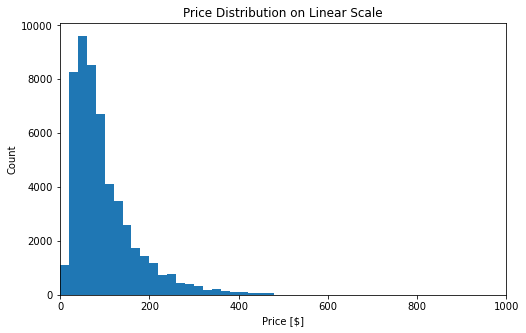

In [55]:
def custom_plot(plt, xlabel, ylabel, title, xtick_locations=None, xtick_labels=None, xlim=None):
    """
    Customizes the properties of a matplotlib plot.

    Parameters:
        plt (object): The matplotlib plot object to be customized.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        title (str): Title for the plot.
        xtick_locations (list or None): Locations of custom x-axis tick marks.
        xtick_labels (list or None): Labels for custom x-axis tick marks.
        xlim (tuple or None): Tuple specifying the x-axis limits.

    Returns:
        None
    """
    # Set the x-axis label
    plt.xlabel(xlabel)
    
    # Set the y-axis label
    plt.ylabel(ylabel)
    
    # Set the plot title
    plt.title(title)
    
    # Customize x-axis tick marks if specified
    if xtick_locations is not None:
        plt.xticks(xtick_locations, xtick_labels)
        
    # Set x-axis limits if specified
    if xlim is not None:
        plt.xlim(*xlim)




# Define a standard color which will be used throughout the notebook
std_color = sns.color_palette()[0]

plt.figure(figsize=(8,5))

# Create bins and plot histogram of prices
bins = np.arange(0,500, 20)
plt.hist(df_listings_clean['price'], bins=bins, color=std_color);

# Customize plot
custom_plot(plt, 'Price [$]', 'Count', 'Price Distribution on Linear Scale', xlim=(0, 1000))

The above plot clearly shows that the distribution of prices is highly right-skewed. While most rental units are clustered in the low price regime, there are a few outliers skewing the distribution, making it difficult to get more detailed insights.

From this, it can be concluded that a linear scale is not proper for displaying the price distribution. Hence, a valid assumption is that prices are actually log-normal distributed. The following plot shows the prices on a logarithmic scale.

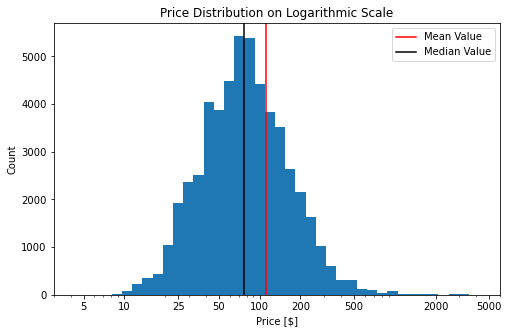

In [85]:
plt.figure(figsize=(8,5))

# Create equal bins on a logarithmic scale and plot histogram
bins = np.logspace(np.log10(1), np.log10(5000), 50)
plt.hist(df_listings_clean['price'], bins=bins)

# Log-transform x-scale
plt.xscale('log');

# Define custom tick labels for better readability and to avoid exponental notation
tick_locations = [5, 10, 25, 50, 100, 200, 500, 2000, 5000]
tick_labels = [str(val) for val in tick_locations]

plt.axvline(df_listings_clean['price'].mean(), color='red', label="Mean Value")
plt.axvline(df_listings_clean['price'].median(), color='Black', label="Median Value")
plt.legend()

# Customize plot
custom_plot(plt, 'Price [$]', 'Count', 'Price Distribution on Logarithmic Scale', 
            xlim=(3, 6000), xtick_labels=tick_labels, xtick_locations=tick_locations)

The above figure clearly shows that prices indeed follow a normal distribution-like shape on a logarithmic scale. Most prices lie in the regime between 50 \\$ and 200 \\$ and only very few fall below 15 \\$ or above 1000 \\$.

However, the right-skewed nature of the price distribution has in fact important consequences for the following analysis. The most important being that the mean value of prices is seriously distorted to higher values by those few large prices. Hence, the mean might in this case not be a proper measure of central tendency for such a distribution (we could of course use the mean of the logarithm of the price).

But as obvious from the above figure, the median seems to be a much more appropriate measure, coinciding with the mean of the log-normal distributtion.
Hence, in the following analysis we will mainly rely on the median as metric for measuring central tendency.

<a id="10"></a> 
## Location Dependent Prices

Now, that we have investigated and understood the price distribution, we are in the position to look at the depdency of prices on some other variables (bivariate investigation). 

The first such dependency we will investigate is the effect on the location of rental units on the price.

However, before looking at the price distributions per neighborhood, it is instructive to get an overview of the number of rental units in each district as shown below:

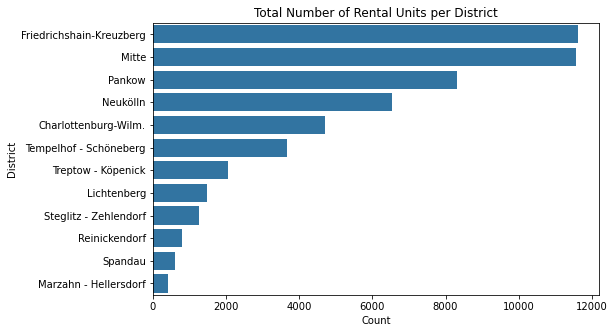

In [86]:
plt.figure(figsize=(8,5))

# Plot barchart showing the number of buildings per neighborhood
sns.countplot(data=df_listings_clean, y='neighbourhood_group_cleansed', color=std_color,
              order=df_listings_clean['neighbourhood_group_cleansed'].value_counts().index)

custom_plot(plt, 'Count', 'District', 'Total Number of Rental Units per District')

The above graph clearly shows that most of the rental units are offered in Friedrichshain-Kreuzberg and Berlin Mitte, which are actually quite districts of Berlin where more wealthy people tend to live and where living generally is quite expensive.

On the other hand, the fewest rental units are offered in the poor and partially dangerous areas of Berlin such as Marzahn-Hellersdorf, Spandau and Steglitz-Zehlendorf.

To further investigate this, we have plotted a simple projection of Berlin using the latitude and longitude information to plot each rental unit at t he correct relative position. Additionally, we have colored each district and made each rental unit's sizing on the graph proportional to its price

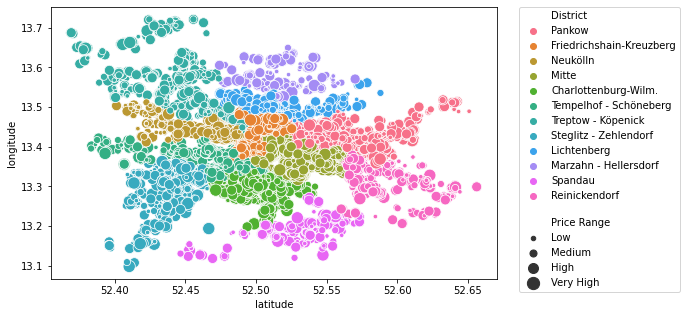

In [87]:
plt.figure(figsize=(8,5))

# Create list of significant price marks
bins = [df_listings_clean['price'].min(), df_listings_clean['price'].quantile(0.25),
        df_listings_clean['price'].quantile(0.5), 1.5*df_listings_clean['price'].quantile(0.75),
        np.inf]

# Use that list to create a norminal data type
bin_labels = ['Low', 'Medium', 'High', 'Very High']
price_category = pd.api.types.CategoricalDtype(categories=bin_labels, ordered=True)

# Use price label data type to cut price into those corresponding to labels: Low, Medium, ...
df_listings_clean['price_labels'] = pd.cut(df_listings_clean['price'], bins=bins, 
                                           right=False, labels=bin_labels).astype(price_category)

# Make a dictioinary to assign each price to. a category
size_mapping = {"Low": 20, "Medium": 50, "High": 100, "Very High": 150}

# Plot latitude and longitude and separate according to district and price range
scatterplot = sns.scatterplot(data=df_listings_clean, x='latitude', y='longitude', hue='neighbourhood_group_cleansed', 
                size='price_labels', sizes=size_mapping)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)



# Get the current legend
legend = plt.gca().get_legend()

# Define custom labels for the groups
custom_labels = {
    'neighbourhood_group_cleansed': 'District',
    'price_labels': '\nPrice Range'
}

# Replace the default group labels with custom names
for text in legend.texts:
    label = custom_labels.get(text.get_text(), text.get_text())
    text.set_text(label)

The main trend becoming obvious from this graph is that high and very high prices rental units seem to gravitate towards the center of Berlin while low priced units seem tobe more likely to find when the distance to the center increases. For example, in Berlin Mitte and Friedrichshain-Kreuzberg (both are quite central) we can barely see any low-priced rental units and very few medium prices ones.

But in the less prestigious districts like Spandau, Marzahn-Hellersdorf and Neukölln it becomes obvious that there is much more balanced price range (these districts reach much further away from the center). Even though, there are also some very expensive rental units - which are mostly closer to the centre - there are also many more low and medium priced buildings available in these areas.

To get a more clear understanding of the price distributions in each district we made a box plot (summary statistics) for each district as well as a violin plot which gives us additional information of the distribution/density of price regimes in the districts

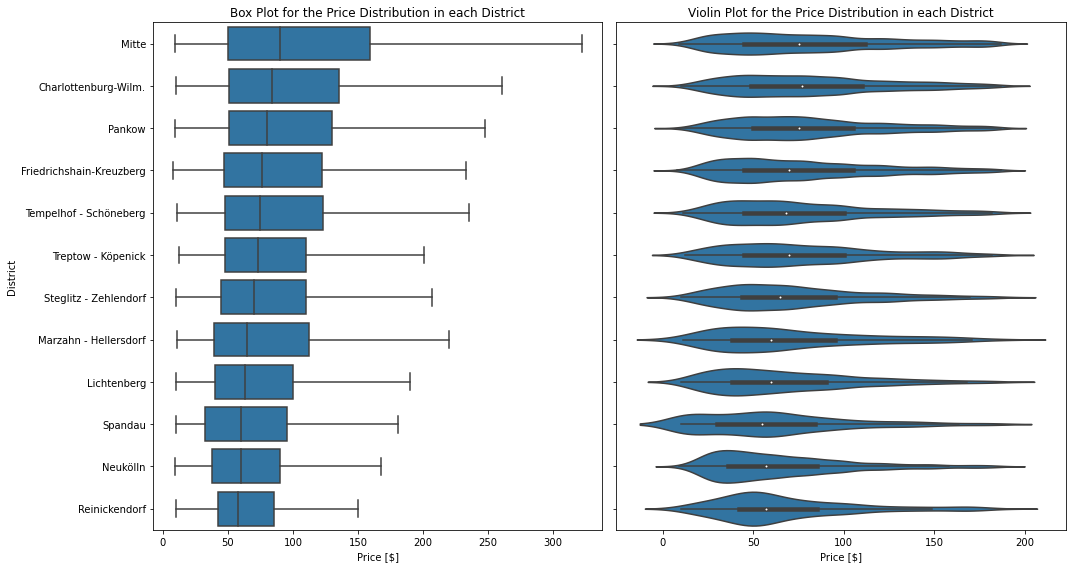

In [89]:
# Group the prices by district and order them in descending order to use it as order parameter in plots
ordered_prices = df_listings_clean.groupby('neighbourhood_group_cleansed')['price'].median().sort_values(ascending=False).index

plt.figure(figsize=(15,8))
plt.subplot(1, 2, 1)
# Make the box plot where price statistics are shown for each district
sns.boxplot(data=df_listings_clean, y='neighbourhood_group_cleansed', x='price',
            showfliers=False, 
            order=ordered_prices, color=std_color)

custom_plot(plt, 'Price [$]', 'District', 'Box Plot for the Price Distribution in each District')


plt.subplot(1, 2, 2)
# Make the violin plot where price statistics/densities are shown for each district
sns.violinplot(data=df_listings_clean[df_listings_clean['price']<bins[-2]], y='neighbourhood_group_cleansed', x='price',
            showfliers=False, 
            order=ordered_prices, color=std_color)

custom_plot(plt, 'Price [$]', '', 'Violin Plot for the Price Distribution in each District')

# Get thecurrent axes
ax = plt.gca()
# Remove tick labels on the y-axis while keeping the ticks
ax.set_yticklabels(['']) ;
plt.tight_layout()

From the box plot above we can clearly see the expected trend of the majority of prices declining when going from renowned and central district like Berlin Mitte to less renowned districts like Spandau and Neukölln. Not only does the median price decline but also the spread or skewness of the distributions.
The median price of a rental unit in Berlin Mitte is almost identical to the 75 % quantile in Neukölln while at the same time the interquantile range in Berlin Mitte is twice as large as that for Neukölln, implying much higher average prices. Similar observation can be made for comparisons between between most other renowned districts and the poorer districts.

The violin plot shows this more clearly. While districts like Reinickendorf and Neukölln have most of their density at the bottom lower end of the price range, the districts at the higher end of the spectrum have much flatter distrbutions at the lower price ranges but are thinner and more spead out.

In summary, it can be concluded that our initial findings of most rental units being available in more wealthy districts could probably simply be explained by the fact that investors are more interested in buying rental units in these areas in order to rent them with a potentially higher profit margin and a higher demand.

In districts known as poor, dangerous or far away from tourist attractions, the demand from tourists might be substantially lower and, hence, the rental costs must be lowered to be attractive or considered at all by tourists

<a id="11"></a> 
## Time Dependent Prices

So far, we have looked at location dependent pricings, i.e. static information. To complement this information we will take a look at price dynamics to get a better overall understanding about AirBnB pricings in Berlin.

Concerning the price dynamics, we are mainly interested in two points for this analysis:
1. How did listing prices develop over the past 10 months?
2. How does the time difference between booking date and actual rental date influence pricing.

We will try to answer these two questions below

In order to figure out how the price median prices evolved over the past 10 months, we used the month of the scraping date of the listings as time indicator. Since the scraping always was performed within the same month for all the listings, this should lead to a fair comparison off listing prices across the year. In order to also determine whether these price differences can be considered as statistically significant, we have also plotted the 95 % confidence interval as vertical lines.

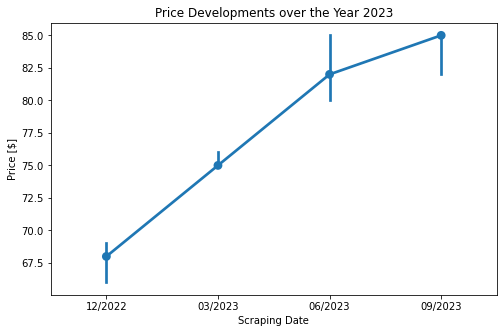

In [91]:
# Obtain the scraping month and year and store them in a new column
df_listings_clean['last_scraped_month'] = df_listings_clean['last_scraped'].dt.month
df_listings_clean['last_scraped_year'] = df_listings_clean['last_scraped'].dt.year

# Create a new ordinal variable for the month
month_category = pd.api.types.CategoricalDtype(categories=[12,3,6,9], ordered=True)
df_listings_clean['last_scraped_month'] = df_listings_clean['last_scraped_month'].astype(month_category)

# Plot the median price including confidence intervals (bootstraping) as function of the month
plt.figure(figsize=(8,5))
sns.pointplot(data=df_listings_clean, x='last_scraped_month', y='price', estimator=np.median)

# Customize plot
scrape_labels = ('12/2022', '03/2023', '06/2023', '09/2023')
custom_plot(plt, 'Scraping Date', 'Price [$]', 'Price Developments over the Year 2023',
            xtick_labels=scrape_labels, 
            xtick_locations=(0, 1, 2, 3))

The above figure clearly shows that the median price over all rental units was increasing strictly monotonically over the past 10 months. At first sight this seems somewhat counterintuitive as it should be expected to see high prices in months of high demand such as during summer and Christmas vacation time. 

But one key factor to keep in mind is that inflation was rising through all of the year 2023 and only started to decline recently (September/October 2023). With this additional piece of information it might be reasonable to assume that the price dyamicss here are not representative of the general price structure of AirBnB rental units in Berlin but are rather an artifact of the unusual rise of inflation and energy prices.

Another interesting observation is that the price differences are from 12/2022 to 06/2023 are all statistically significant ($\alpha < 0.05$) but the price increase from 06/2023 to 09/2023 is not statistically significant, which might strengthen our hypothesis about the impact of inflation, i.e. there was no significant increase in prices anymore when inflation was started to decrease.

However, to dig deeper into these price dynamis we would need to compare our data to other years's data and also look at the correlation of inflation and other factors.

Now, that we got some interesting insights into the overall price dynamics over almost an entire year, it is time to get some more fine-grained information on price dynamics. For this, we will have a look at the price evolution for a given booking date (here: given by different scraping months) and look at how the AirBnB calendar price evolves as the time between booking/scraping and planned stay increases.

In order to be able to compare all four scraping periods, we will only look at data ranging from 09/2023 to 12/2023, since the most recent scraping period was 09/2023 and calendar data scraped on 12/2022 is only available for one year, i.e. 12/2023.

In [61]:
# Do the same for calendar table as we just did for listings table, i.e. extract scraping month and year
df_calendar_clean['last_scraped_month'] = df_calendar_clean['last_scraped'].dt.month
df_calendar_clean['last_scraped_year']  = df_calendar_clean['last_scraped'].dt.year

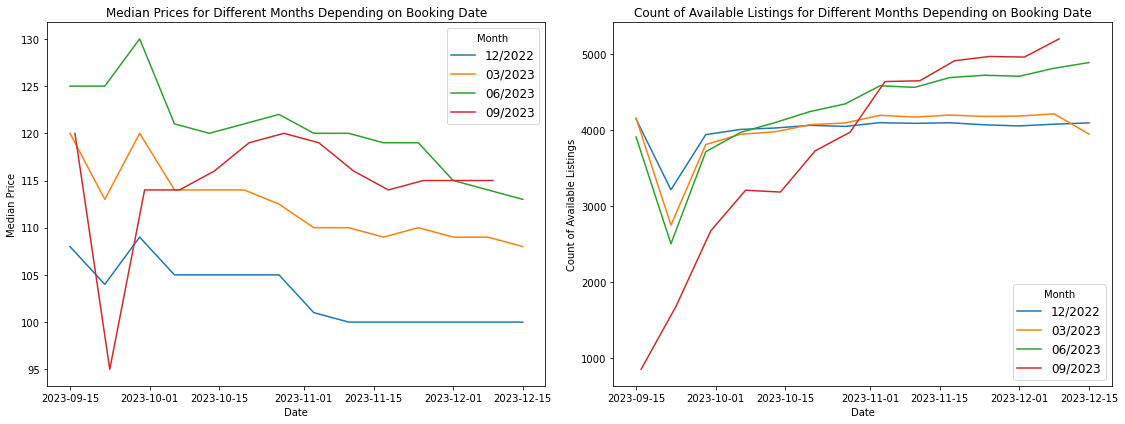

In [92]:
def filter_and_group_data(data, month, start_date, end_date):
    """
    Filter and group data for a specific scraping month and date range, returning both median and count data.

    Parameters:
        data (DataFrame): The DataFrame containing the data to be filtered and grouped.
        month (int): The target month for filtering (e.g., 1 for January).
        start_date (str): The start date for the date range (inclusive), in the format 'YYYY-MM-DD'.
        end_date (str): The end date for the date range (inclusive), in the format 'YYYY-MM-DD'.

    Returns:
        grouped_median (DataFrame): Median data grouped by date and sampled every 7 days.
        grouped_count (Series): Count data grouped by date and sampled every 7 days.
    """
    # Create a mask which filters by matching scraping month, the specified start and end date and availability
    filtered_data = data[
        (data['last_scraped_month'] == month) 
        & (data['date'] >= start_date) 
        & (data['date'] <= end_date) 
        & (data['available'] == 1)
    ]
    
    # Group filtered data by date and compute median and count
    grouped_median = filtered_data.groupby('date').median().iloc[::7]
    grouped_count = filtered_data.groupby('date').size().iloc[::7]
    
    return grouped_median, grouped_count

# Define the date range (Only dates where we have data for all months scraped)
start_date = '2023-09-15'
end_date = '2023-12-15'

months = [12, 3, 6, 9]  # Specify the scraping months

# Get the filtered data from start_date to end end_date for each scraping prediod
filtered_data = [(month, filter_and_group_data(df_calendar_clean, month, start_date, end_date)) 
                 for month in months]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6)) 

# Plot median prices and count of available listings and label legend
idx = 0
for month, (median_data, count_data) in filtered_data:
    ax1.plot(median_data.index, median_data['price'], label=scrape_labels[idx])
    ax2.plot(count_data.index, count_data, label=scrape_labels[idx])
    idx += 1

# Customize the median price plot
ax1.set_title('Median Prices for Different Months Depending on Booking Date')
ax1.set_xlabel('Date')
ax1.set_ylabel('Median Price')
ax1.legend(title='Month', fontsize=12)

# Customize the count plot
ax2.set_title('Count of Available Listings for Different Months Depending on Booking Date')
ax2.set_xlabel('Date')
ax2.set_ylabel('Count of Available Listings')
ax2.legend(title='Month', fontsize=12)

# Adjust spacing between subplots
plt.tight_layout()

The left graph above shows the median calendar price evolution for different scraping months (booking dates), while the right graph shows the number of available (bookable) rental units as function of the same variables.

It can clearly be seen that for each bookable date the prices increase depending from 12/2022 to 06/2023. This finding could probably be explained by the observations made earlier about inflation and increased energy/maintenance costs. More interesting is, however, the fact that prices around 03/10/2023 spike for all three of these booking dates. It should be kept in mind that 03/10/2023 is an important German holiday, i.e.  this holiday already seems to be priced in either automatically by AirBnB or manually by the hosts such that prices increase around that holiday.
After that holiday the prices seem to be slightly decreasing but there are no more peaks but rather a constant but very subtl decline.

For the booking closest to the aforementioned holiday, i.e. the booking made in 09/2023, the sharp price increase is not present. It seems rather, that as if bookings made about one two weeks in advance to the actual rental date seem to be the cheapest (on discount) with an a sharp increase later on to similar prices as the rental units booked longer in advance. This seems reasonable since most people probably book their trips only a few weeks before the actual trip, leading to more competition by hosts, 

Concerning the the number of available listings it can be seen that the fewest listings are available for 09/2023 for booking made within the same month. This couldl probably simply be explained by the fact that that hosts need time to prepare their houses. However, another interesting finding is that the number of available rental units during the whole year (12/2022 - 12/2023) seems to be slowly changing and mostly stays around 4000 available units. These units which are available throughout the whole year are probably used by commerical investors rather than people renting their home while being away.

<a id="12"></a> 
## Dependence of Price on Amenities

Now, that we have taken a look at the big picture in terms of pricings depending on location and overall price dynamics, we will take a look at a seemingly fine-grained look at price in terms of amenities. But the idea here is that amenities might actually tell as much -- if not more - as the location of a building.

If we were to invest in a rental unit or try to level up an existing one, checking for amenities present in expensive rental units might be worthwhile if we could figure out some common amenities which are more present in expensive units. Together with the location this information we got from location dependent prices this could help us to decide which units are worthy investments. Combining this with the time information might help us estimate a profitable and and competitive price throughout the year.

We will start this section again by a rather simple exploratory analysis showing the most frequently occuring amenities in the overall dataset. The following plot shows the percentages of homes with those amenities:

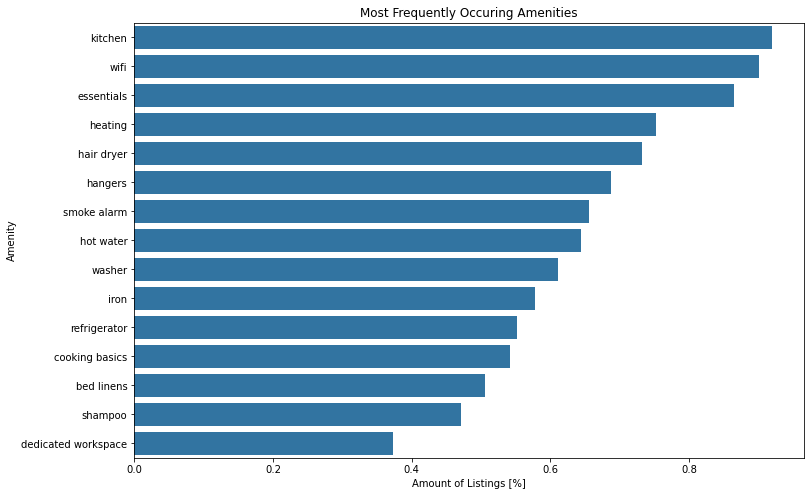

In [96]:
# Get list of amenity columns
amenities_cols = df_listings_clean.columns[df_listings_clean.columns.str.startswith('amenities')]

# Sum the binary values for each amenity
amenities_counts = df_listings_clean[amenities_cols].mean().sort_values(ascending=False).iloc[:15]

# Create a countplot and format amenities names' properly
plt.figure(figsize=(12, 8))
sns.barplot(x=amenities_counts.values, 
            y=amenities_counts.index.str.replace('amenities_','').str.replace('_',' '), color=std_color)

# Customize plot
custom_plot(plt, 'Amount of Listings [%]', 'Amenity', 'Most Frequently Occuring Amenities')

The above graph shows that the top amenities are rather generic things like having a kitchen, wifi, heating, essential stuff etc. About 70 % to 90 % of rental units have these amenities. More specific things like. shampoo, bed linens and cooking basics are less frequently found, eben though they might be implied in "essentials"

In order to dig deeper into the distribution of amenities and investigate patterns in prices, we will now divide the dataset into two parts based on prices. The first dataset contains only amenities, which are more often present in expensive rental units and the second part will contain only contain amenities present which are more present in low-priced rental units. Both of these datasets will be plotted in a separate bar chart which shows the corresponding amenities and their relative frequency. This should give us some interesting insights into more which amenities could be important for a high priced rental unit and which descriptions shhould be avoided.

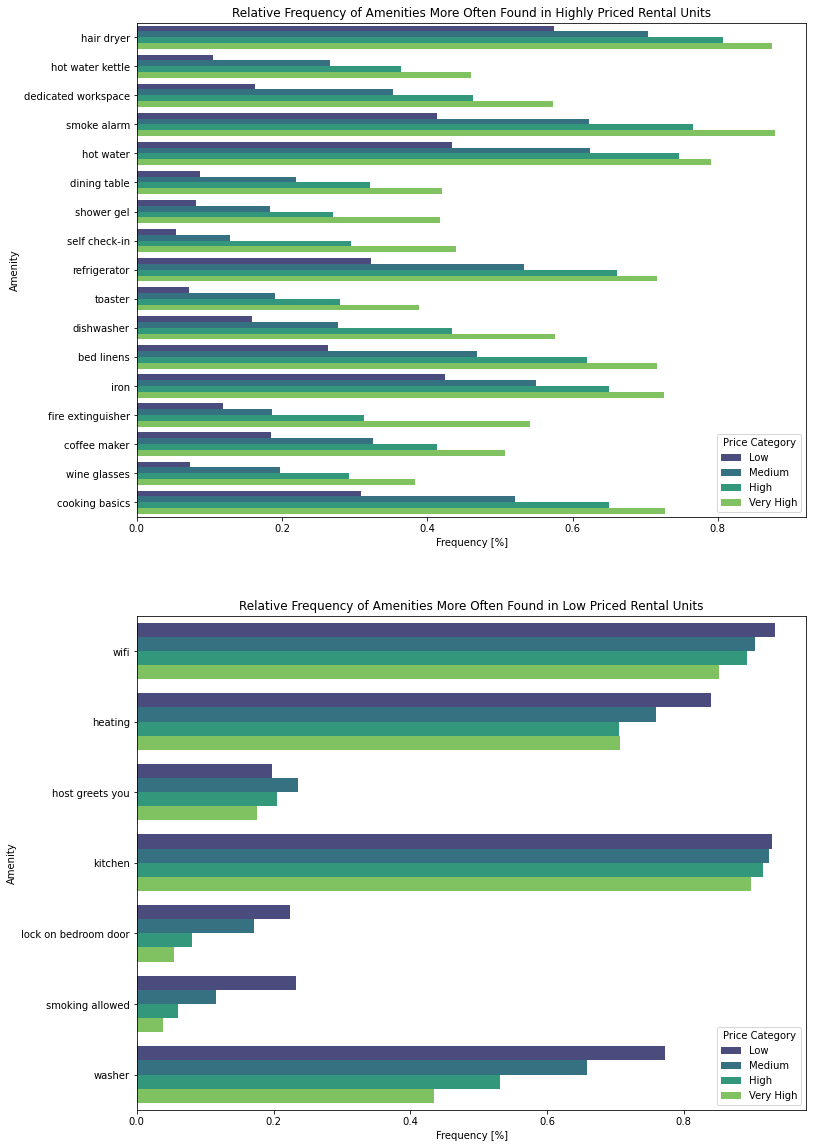

In [98]:
def melt_and_plot_amenities(df, iplot, xlabel, ylabel, title):
    """
    Create a bar plot of amenity distribution by price labels.

    Parameters:
        df (DataFrame): Input DataFrame with 'price_labels' and amenity columns.
        iplot (int): Subplot index for displaying the plot.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        title (str): Title of the plot.

    Returns:
        None

    This function reshapes the input DataFrame using melt and creates a bar plot
    to visualize amenity distribution by price labels. Customize the axis labels and title
    using the provided parameters.

    Example:
        melt_and_plot_amenities(df, 1, "Count", "Amenity", "Amenity Distribution by Price Labels")
    """
    df.reset_index(inplace=True)

    plt.subplot(2, 1, iplot)
    # Reshape the DataFrame using melt to get separate column specifying the amenity
    melted_df = df.melt(id_vars=['price_labels'], var_name='amenity', value_name='count')
    melted_df['amenity'] = melted_df['amenity'].str.replace('amenities_','').str.replace('_',' ')

    # Make bar plot of relative amenity count differentiated by price labels
    sns.barplot(data=melted_df, y='amenity', x='count', hue='price_labels', palette='viridis')
    # Customize plot
    custom_plot(plt, xlabel, ylabel, title)
    plt.legend(title='Price Category')
    

# Group price amenities columns by price labels and take compute the mean amenity count for each price label
amenities_counts = df_listings_clean.groupby('price_labels')[amenities_cols].mean()

# Get amenities which are more often present not more present in very high priced rental units
high_diff_cols = amenities_counts.columns[(amenities_counts.iloc[0,:]-amenities_counts.iloc[3,:])>-0.3]
# Get amenities which are more often present not more present in very low priced rental units
low_diff_cols = amenities_counts.columns[(amenities_counts.iloc[0,:]-amenities_counts.iloc[3,:])<0.02]

# Get table only consisting of amenities more present in very high priced rental units
amenities_high = amenities_counts.drop(columns=high_diff_cols, axis=1)
# Get table only consisting of amenities more present in very low priced rental units
amenities_low = amenities_counts.drop(columns=low_diff_cols, axis=1)

plt.figure(figsize=(12,20))
melt_and_plot_amenities(amenities_high, 1, 
'Frequency [%]','Amenity','Relative Frequency of Amenities More Often Found in Highly Priced Rental Units')
melt_and_plot_amenities(amenities_low, 2, 
'Frequency [%]','Amenity','Relative Frequency of Amenities More Often Found in Low Priced Rental Units')

From the upper graph showing the amenities more often present in high-priced buildings it becomes obvious that these are mostly very specific things like iron, toaster, coffee maker and so on. 

A very interesting and surprising finding is that emergency equipment like smoke alarm, fire extinguisher are much more often found in higher prices rental units (60 % - 80 %) but are only available in at most 40 % of the low priced units.

However, also very convenient amenities like dishwasher, refrigerator, self check-in, etc. are also much more often found inn higher priced amenities. 


Concerning the lower amenities more often found in lower priced amenities the differences are mostly in frequency are mostly much less pronounced. Smoking being allowed seems to be mostly present in lower priced rental units which makes sense since the value of a property usually decreases if smoking is allowed. 
The washer being present more often in lower priced buildings is also understandable since by "washer" it is mostly referred to a coin-base washing machine or the presence of a washing shop nearby according to the AirBnB forums. Having a coin-based washer advertised for an expensive rental unit repel wealthy customers.

<a id="13"></a> 
## Most Influential Factors on Price: Correlation, Regression and Information Analysis

Now,that we have analyzed our data and got some very interesting insights which lead to conclusions and inferences on why certain variables behave in a certain way, the final step of this project is to figure out which features of our dataset influence prices the most. 

This could for example tell us on whether we have already investigated all of the most important variables or be the starting point on asking new questions  about our data and guide us in new directions. Especially since our dataset is very high dimensional, it is natural that not all the directions can be covered. Hence, the way this analysis was structured so far is just natural, i.e. first investigating obviously interesting features of our datase and then to wonder what other features are worth to analyse.

This part of the analysis will be structured as follows:

1. We will look at the correlations of our data to see if we might need to use some tricks to avoid multicollinearities.

2. We will prepare our data for a linear regression model. The reason we choose such a simple model is that we are in this project actually not interested in making highly accurate predictive model but rather are more interested to interpret the model such that we can gain insights in the into the features which influence prices the most. Hence, a simple interpretable model like linear regression could be suitable for that. In case, the problem does turn out not be linear, we can still try other models like random forests.

3. We analyse the regression analysis in terms of its coefficients to find important features.

4. We will additionally look at the mutual information scores. These also capture non-linear effects and might yield more trustworthy information on pairwise relationships (prics vs. X) than linear regression.

Make a copy of our listings dataframe which we will work with in the following:

In [65]:
df_ml = df_listings_clean.copy()

<a id="14"></a> 
### 1. Feature Investigation Based on Pearson Correlation

#### 1.1 Plot a heatmap to get an overview of correlations among features

Text(0.5, 1.0, 'Heatmap indicating the Correlation Strength Among Features')

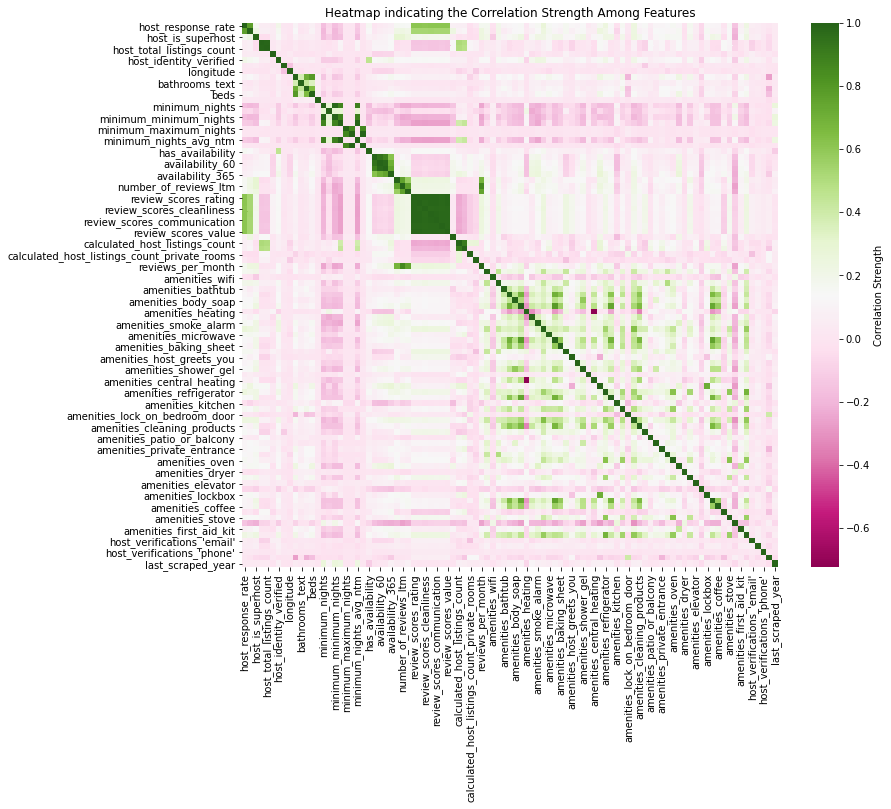

In [66]:
plt.figure(figsize=(12,10))
sns.heatmap(data=df_ml.corr(), cmap='PiYG', cbar_kws={'label': 'Correlation Strength'})
plt.title('Heatmap indicating the Correlation Strength Among Features')

The above heatmap shows that while most features are rather uncorrelated there seem to be certain clusters which are strongly positively correlated. These strongly correlated clusters seem mostly among the review based as well as among the amenity features. This makes intuitive sense since a satisfied customer is likely to not differentiate that much but rather give a 5-star rating all across the board.

For the amenities this also makes intuitive sense since e.g. the presence of coffee maker or a toaster likely implies the presence of a kitchen.

Another interesting observation is that the host response rate and the host response rate seem to be positively correlated with thhe review scores, i.e. fast responding hosts and super hosts are likely to receive more positive rattings due to their commitment or their commercial invest since it is their business to rent appartments.

#### 1.2 Plot a barchart to investigate the correlations between features and our target variable (price)

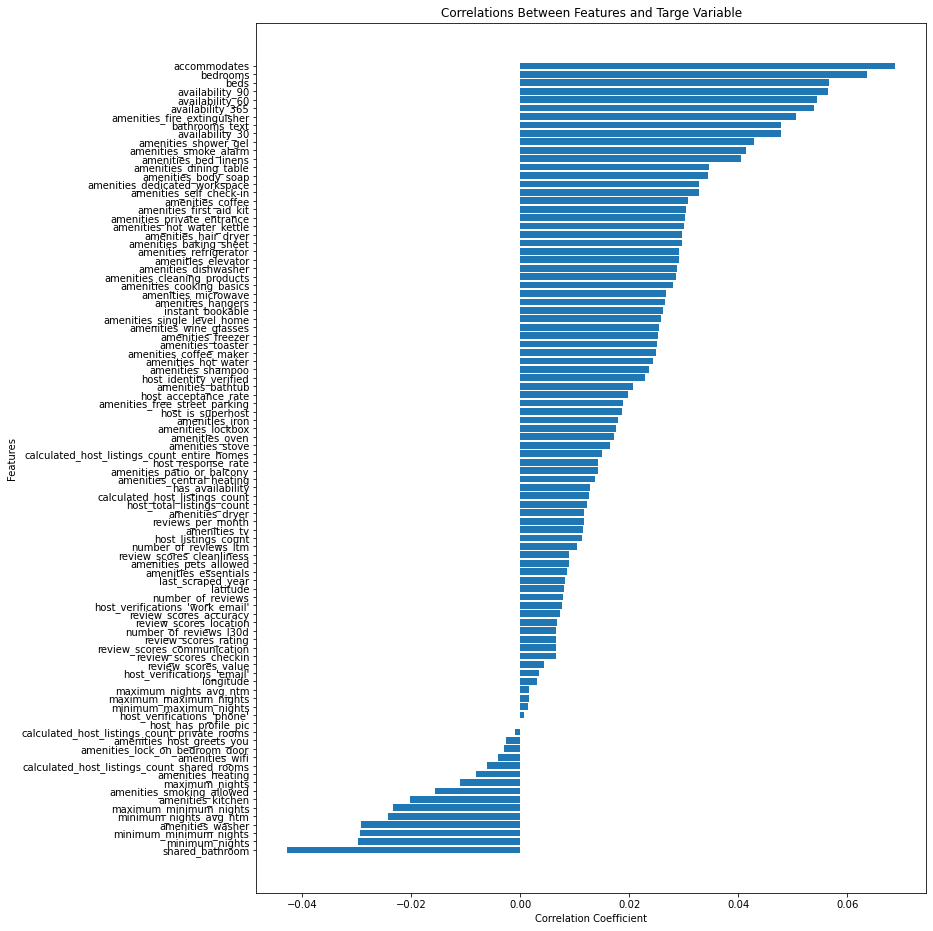

In [99]:
plt.figure(figsize=(12,16))

# Create a mask such that price column is excluded from plot (it is =1 anyways)
price_mask = (df_ml.corr().price.index != 'price')

sorted_df = df_ml.corr()[price_mask].price.sort_values(ascending=False)

# Plot bar plot to check correlation of features and price
plt.barh(sorted_df.index, sorted_df.values)
plt.gca().invert_yaxis()
custom_plot(plt, 'Correlation Coefficient', 'Features', 'Correlations Between Features and Targe Variable')

Interestingly, there does not seem to be a feature which is strongly correlated with price. Most features seem to be rather weakly correlated.

However, there are still some interesting trends obvious from the above plot:

The highest positive correlations seem to  in the number of bath and bedroooms, which is reasonable as prices increase the larger the rental unit is what the number of beds/bedrooms/bathrooms is a good indicator for. Also the correlation of price and availability in 30, 60 and 365 days indicates that commcercially rented units tend to be more expensive.

Additionally, we see similar trends to what we observed previously when looking at the amenities present more often present in expensive rental units, i.e. specific convenient amenities like having a microwave seems to be more often present in expensive rental units.

Concerning negative correlations, we additionally see the strongest negative correlation is present in shared_bathroom column, which makes intuitive sense since generally shared rental units are cheaper.

<a id="15"></a> 
### 2. Data Preparation

#### 2.1. Start by checking if there are any categorical or string type columns we might want to use in our analysis by using one-hot-encoding:

In [68]:
df_listings_clean.select_dtypes(include='object').head(1)

,id,host_response_time,neighbourhood_group_cleansed,property_type,room_type
0,3176,within an hour,Pankow,Entire rental unit,Entire home/apt


In [69]:
df_listings_clean.select_dtypes(include='category').head(1)

,price_labels,last_scraped_month
0,High,9


As we have seen earlier, the neighborhood/district should definitely be included in our regression model but also the room type might be an indicator for price

#### 2.2. Create dummy variables for neighborhood/district and room type columns

In [70]:
# List of columns we wanna one-hot encode
dummy_cols  = ['room_type', 'neighbourhood_group_cleansed']

# Loop over columns and one-hot encode them (drop first column to avoid redundancies)
for col in dummy_cols:
    df_ml = pd.concat([df_ml.drop(columns=col, axis=1), 
                      pd.get_dummies(df_ml[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)

#### 2.3. Select relevant columns and divide dataset into a feature matrix and a target vector

In [71]:
df_ml = df_ml.select_dtypes(include=['int', 'float'])

X = df_ml.drop(columns='price')
y = df_ml['price']

#### 2.4. Preprocess Data: Remove Outliers, Log-Transform Targets

We have previously seen that prices seem to follow a log-normal distribution. The large range of values and the fact that the residual errors of prices on a "regular" scale will probably not satisfy the assumptions made by linear regression, implies that prices (targets) should be log-transformed to be suitable for linear regression.

Additionally, we saw some rather big outliers in prices. A log transformation is will not remove those outliers. Furthermore, the outliers should be detected on the log-scaled targets in order to result in a proper normal distribution (on a log-scale).

Here, the outliers will be removed based on the interquantile range. All points above or below 25 % and 75 % quantile +/- the IQR will be removed since outliers will negatively influence our regression model.

In [72]:
# How many data did we have before outlier removal?
n_init = y.shape[0]

# Log-transform y
y = np.log(y)

# Compute interquartile range
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the data frame (Remove outliers)
y = y[(y >= lower_bound) & (y <= upper_bound)]
X = X[(np.log(df_ml['price']) >= lower_bound) & (np.log(df_ml['price']) <= upper_bound)]

print('Outliers removed in total', n_init - y.shape[0])
print('Outliers removed relative o dataset size', (n_init - y.shape[0])/n_init)

Outliers removed in total 488
Outliers removed relative o dataset size 0.009200429856149018


The amount of outliers we removed seems very small. Hence, this should not change the results of our analysis.

#### 2.5. Split Data in Traing and Test Set

In [73]:
# Split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape y for sklearn
y_train = y_train.values.reshape(-1, 1)
y_test  = y_test.values.reshape(-1, 1)

#### 2.6. Standardize the Feature Vectors of Train and Test Set using Standardscaler

In [74]:
# Initialize Standardscaler and only fit on training data to avoid data leakage
X_scaler = StandardScaler()
X_scaler.fit(X_train)

# Transform training and test data using standardscaler (standardisation of y is not necessary)
X_train_scaled = X_scaler.transform(X_train)
y_train_scaled = y_train
X_test_scaled  = X_scaler.transform(X_test)
y_test_scaled  = y_test

<a id="16"></a> 
### 3. Regression Analysis

#### 3.1. Perform Linear Ridge Regression

We have seen from the heatmap over features that we have some strongly correlated feature pairs. This might be problematic since it can cause multicollinearities (linear depencies) which might cause the linear regression algorithm to either not converge or to yield unreliable results.

To take this into account we will here perform ridge regression, i.e. linear regression using a L1 regularization term. This regularization term should be able to take care of these multicolinearities by giving them zero weights.

Furthermore, we perform cross validation and a grid search across a reasonable range of regularization parameters.

In [75]:
# Initialize ridge regression with range values for \lambda to scan
ridge = RidgeCV(alphas=np.arange(1e-3, 1000, 10000))

# Fit ridge regression on training data
ridge.fit(X_train_scaled, y_train_scaled)

# Making predictions on test and training data
ridge_pred = ridge.predict(X_test_scaled)
ridge_pred_train = ridge.predict(X_train_scaled)

# Print model evaluation metrics (R2 score and MSE) for train and test set
print(f"Ridge Regression MSE (Test data): {mean_squared_error(np.exp(y_test_scaled), np.exp(ridge_pred))}")
print(f"Ridge Regression R2-Score (Test data): {r2_score(y_test_scaled, ridge_pred)}")
print(f"Ridge Regression MSE (Train data): {mean_squared_error(np.exp(y_train_scaled), np.exp(ridge_pred_train))}")
print(f"Ridge Regression R2-Score (Train data): {r2_score(y_train_scaled, ridge_pred_train)}")

# Perform a simple estimation
y_mean = np.ones([y_train_scaled.shape[0]])*y_train_scaled.mean()
print(f"MES for naive mean estimation: {mean_squared_error(np.exp(y_train_scaled), np.exp(y_mean))}")

Ridge Regression MSE (Test data): 2741.271275537293
Ridge Regression R2-Score (Test data): 0.6247825263703983
Ridge Regression MSE (Train data): 2878.2598103042947
Ridge Regression R2-Score (Train data): 0.6264613917370785
MES for naive mean estimation: 6313.402714116708


The above results suggest that our linear regression model does not generalize well. The R2-scores and MSEs for the training and test set are almost identical. This could hint at the fact that there is a systematic error/problem with our fit. The model perform better than a simple mean estimation but mean squared error are quite large and the R2-values are <<1 which suggests that a linear model is not appropriate for modeling prices or that the inclusion of higher order terms (interactions, quadratic terms) might improve results.

However, including higher order terms would also make the model less  interpretable. Since the aim of this analysis is not to get a perfect ML model for price predictions but rather to understand the importance of features on the price, we will stay away from including higher order terms.

#### 3.2. Analyzing the Regression Coefficients
Below, we have made a plot of the regression coefficients order by their importance in order to compare these (probably untrustworthy) results to the results previously obtained from the correlation coefficient analysis.

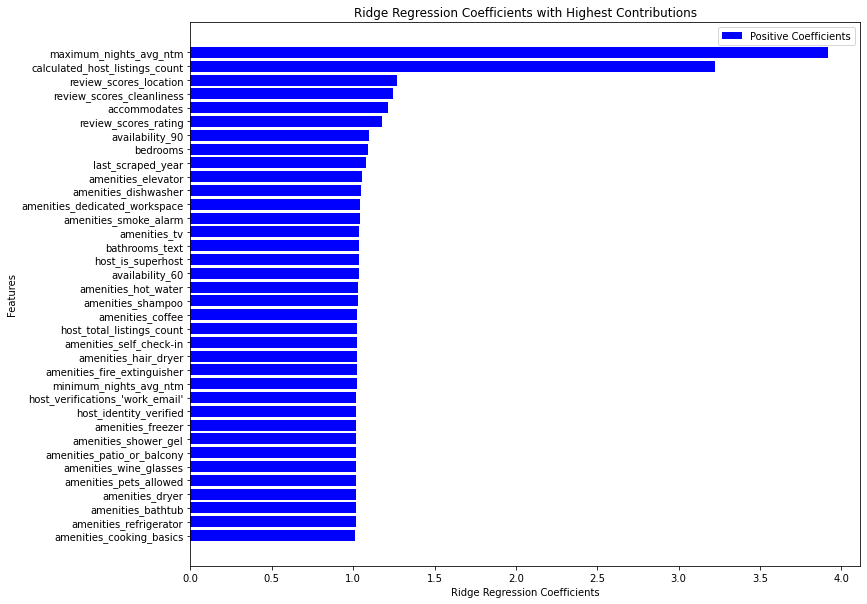

In [101]:
# Get the coefficients from Ridge Regression
coefficients = ridge.coef_

# Back-transform the coefficients to the original scale
coefficients_original_scale = np.exp(coefficients).ravel()

# Create a DataFrame to store the coefficients with feature names
coefficients_df = pd.DataFrame({'Feature': X_train.columns, 
                                'Coefficient': coefficients_original_scale}).sort_values(by='Coefficient', 
                                                                                         ascending=False)

# Split the coefficients into positive and negative
positive_coeffs = coefficients_df[coefficients_df['Coefficient'] > 1.01]
negative_coeffs = coefficients_df[coefficients_df['Coefficient'] < 0]

# Extract values as arrays
positive_values = positive_coeffs['Coefficient'].values
negative_values = negative_coeffs['Coefficient'].values
positive_features = positive_coeffs['Feature'].values
negative_features = negative_coeffs['Feature'].values

# Create a bar plot of positive and negative coefficients
plt.figure(figsize=(12, 10))
plt.barh(positive_features, positive_values, color='b', label='Positive Coefficients')
if len(negative_values>0): 
    plt.barh(negative_features, negative_values, color='r', label='Negative Coefficients')
    
# Customize plot
custom_plot(plt, 'Ridge Regression Coefficients', 'Features', 
            'Ridge Regression Coefficients with Highest Contributions')
# Invert y-axis to get desired ordering
plt.gca().invert_yaxis()
plt.legend();

Overall the results (especially concerning the amenities) are very similar to the results we analysed above in terms of correlation coefficients. Hence, this analysis will not be repeated here.

However, there are two important differences to the previous correlation analysis. While for the correlation analysis we saw that 'maximum_nights_avg_ntm' and 'calculated_host_listings_count' had a rather low to medium correlation, these two columns are now the most important for the regression model. It makes intuitive sense that the maximum number of nights spent correlates positive with the price here in the linear regression analysis since the time spend in a building is proportional to the price.

But the fact that there are only two coefficients, with a major impact and all the others stay at around the same value (1 or below) seems quite off.

<a id="17"></a> 
### 4. Analysis of Feature Importance in Terms of Mutual Information

In our previous regression analysis we were quite skeptical about the results of our model.  Especially, the fact that both linear regression and correlation analysis yielded very similar results and we found that the linear regression model did not perform very well, makes the results from these two analysis rather questionable and raises the question whether a linear model (Pearson correlation coefficients also assume linear relationships) is an appropriate choice to investigate the price.

Hence, as a next step, we performed a analyssis based on mutual information which - similar to the correlation coefficients - also investigates pairwise relationships. However, the key difference is that mutual information is also able to capture non-linear effects. Hence, this analysis might help us understand whether our linear model just performed poorly because of some improper scaling or some other mistake or whether price in fact does not behave linearly as function of the features.

To analyse the mutual information we have made a bar plot with, which shows the most important features according to the mutual information score.

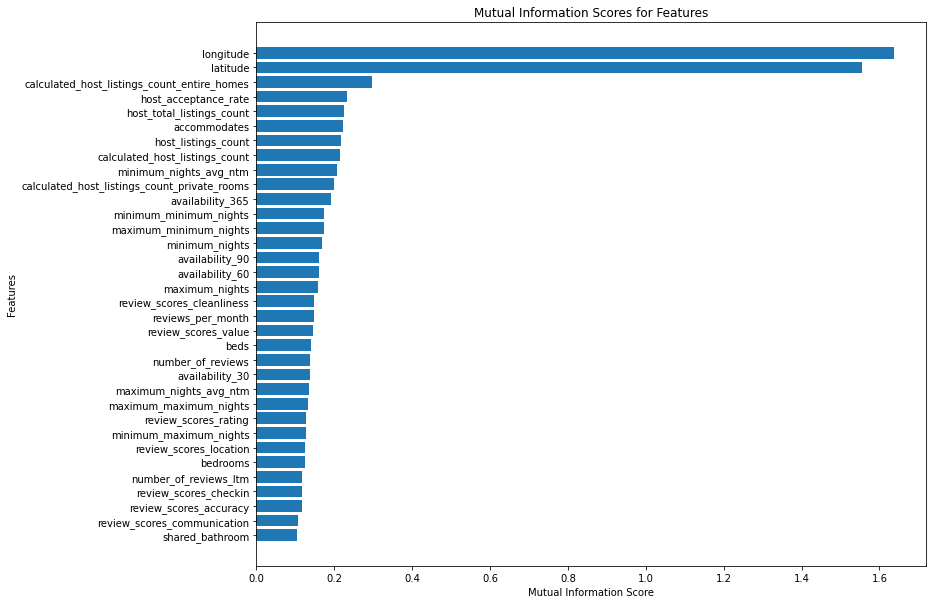

In [103]:
# Compute Mutual Information (choose mutual_info_regression or mutual_info_classif)
# Mutual information is invariant under invertible transformations => We can use our original unscaled data
mi_scores = mutual_info_regression(X, y)

# Create a DataFrame to store the feature names and their MI scores
mi_df = pd.DataFrame({'Feature': X.columns, 'MI_Score': mi_scores})

# Sort the DataFrame by MI Score in descending order
mi_df = mi_df.sort_values(by='MI_Score', ascending=False)

# Create a bar plot to visualize the features with highest MI scores
plt.figure(figsize=(12, 10))
plt.barh(mi_df[mi_df['MI_Score']>0.1]['Feature'], mi_df[mi_df['MI_Score']>0.1]['MI_Score'])

# Invert y-axis to display highest MI scores at the top and customise plot
plt.gca().invert_yaxis()
custom_plot(plt, 'Mutual Information Score', 'Features', 'Mutual Information Scores for Features')

The mutual information (MI) scores look very different from the linear regression (LR) analysis. There are some very interesting differences:

- The location of a building in terms of actual location in space (latitude/longitude) seems to be to most important aspect according to the MI scores. This seems to be much more important than the pure information on the district.  This confirms our initial findings where we have already observed that the further away from the center a building is the the more the price seems to decrease.

- We also see the 'accomodates' and several 'host_listings_count' column here which also seemed important according to the LR analysis.

- However, the effect of amenities seems to have been overesimated in our LR and correlation analysis and the effect of reviews might have been underestimated since according to the MI analysis the effect of ratings is higher ranked here than any amenity column.

<a id="18"></a> 
### Just For Fun: Using a Non-Linear Regression Model for Price Predictions

Out of curiosity we want to check the performance of a non-linear model for price predictions. For this, we use a support a vector machine (SVM) regressor with a radial bass function (RBF) or square exponential (SQE) kernel to see if such a model would perform better out of the box than our optimized linear ridge regression.

In [78]:
from sklearn.svm import SVR
svr = SVR(kernel='rbf')

# Fit ridge regression on training data
svr.fit(X_train_scaled, y_train_scaled)

# Making predictions on test and training data
svr_pred = svr.predict(X_test_scaled)
svr_pred_train = svr.predict(X_train_scaled)

# Print model evaluation metrics (R2 score and MSE) for train and test set
print(f"SVR Regression MSE (Test data): {mean_squared_error(np.exp(y_test_scaled), np.exp(svr_pred))}")
# print(f"SVR Regression R2-Score (Test data): {r2_score(y_test_scaled, svr_pred)}")
print(f"SVR Regression MSE (Train data): {mean_squared_error(np.exp(y_train_scaled), np.exp(svr_pred_train))}")
# print(f"RSVR Regression R2-Score (Train data): {r2_score(y_train_scaled, svr_pred_train)}")

/Users/au672917/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVR Regression MSE (Test data): 1385.8202979231946
SVR Regression MSE (Train data): 956.361714911848


As can be seen from the MSE the SVM performed much better than our LR. Already without any hyperparameter optimization, the MSE is less than half of that of the LR model.

Actually, we should perform a hyperparameter optimization but this is computationally not feasible with the avialable resources due to the high dimensional feature space. Of course, performing a dimensionality reduction of the feature vector like e.g. a principal component analysis (PCA) might help overcome this hurdle but doing predictive modelling is and was not the aim of the present study.

### Summary

Our analysis here yielded some interesting insights: 

- First of all, we got some strong indication that price does not scale linearly with our feature set.
- Hence, we belief that the conclusions we drew from the linear regression and correlation analysis might not be trustworthy.
- The mutual information, which does not assume any linear relationship - yielded results which were far more convincing in terms of intuition and our prior analysis.
- The main finding here is that it seems like the location of a rental unit in terms of spatial coordinates seems to influence the price by far the most. The interesting point about this finding is that this infomation seems to be far more important than the actual label of the district the renal unit is located in.

<a id="19"></a> 
# Conclusions

The analysis shown here yielded the following main insights:


### Price Dependent Locations
- The distribution of rental units is highly skewed to more wealthy/renowned/expensive districts. There are many more rental units in those districts than in the poorer/more problematic ones.
- Looking at Berlin as a whole, most of the expensive buildings are close to the center and the amount of cheaper to medium priced rental unit seems to increase the further away from the center one goes.
- The prices in the wealthier districts seem to span a much wider range while a lesser amount of the rental units seems to be in the lower price range. For the poorer districts the opposite holds.

### Price Dynamics
- Prices seem to have increased significantly over the past 10 month. There was a strictly monotonic increase over the whole year which only seems to have flattened quite recently (September 2023).
- From our limited data we came to the conclusion that booking a unit one to two weeks before the actual stay seems to yield cheaper prices compared to to booking far ahead of the actual stay.
- AirBnB (or the hosts) seem to increase prices automatically on certain special holidays, irrespective of the booking date.

### Price Dependent Amenities
- There seem to be some distinguishing factors concerning the amenities in expensive rental units compared to cheaper ones.
- Cheaper buildings rental units seem to only have mentioned very generic amenities like wifi or kitchen.
- More expensive expensive rental units seem to be much more specific about the amenities as they e.g. tend to mention things like wine gllasses and other convenience amenities like microwaves, refrigerators and so on.
- Surprisingly, safety equipment like smoke alarms and fire extinguishers are much more often present in expensive rental units.

### Most Influential Features on Price
- Price dependence on features is probably not properly described by a linear model.
- Mutual information seems to give more useful insights than linear regression coefficients as this metric does not assume linear relationships.
- According to mutual information the most influential feature on price are the spatial coordinates of a rental unit suggesting that the location within a district is more influential than the district label itself.
- Mutual information gave us some guidance on what we might have neglected and should investigate more carefully such as e.g. the influence of ratings on price.